In [22]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)

In [23]:
df = pd.read_csv(
    "./data/call-center-data-v2-daily.csv",
    usecols=["Date", "Incoming Calls", "Talk Duration (AVG)", "Waiting Time (AVG)"],
)

df = df.loc[(df["Date"] >= "2025-03-01") & (df["Date"] < "2025-06-01")]
df = df.reset_index(drop=True)

In [24]:
def timestamp_to_seconds(ts) -> int:
    """Convert timestamp to seconds.

    Args:
        ts (str): Timestamp in the format "HH:MM:SS"

    Returns:
        int: Total seconds
    """
    h, m, s = map(int, ts.split(":"))
    return h * 3600 + m * 60 + s


df["Talk Duration (AVG)"] = df["Talk Duration (AVG)"].apply(timestamp_to_seconds)
df["Waiting Time (AVG)"] = df["Waiting Time (AVG)"].apply(timestamp_to_seconds)

In [25]:
df["Product Group"] = "PRODUCT_ABC_DESKTOP_EN_CHAT"

# Daily forecasts

In [ ]:
# Create synthetic time series for additional product groups
rng = np.random.default_rng(42)

base_df = df.copy()


def make_variant(
    dataframe,
    product_name,
    *,
    incoming_scale,
    incoming_noise,
    talk_scale,
    talk_noise,
    wait_scale,
    wait_noise,
):
    variant = dataframe.copy()
    variant["Product Group"] = product_name
    variant["Incoming Calls"] = np.clip(
        np.round(
            variant["Incoming Calls"] * incoming_scale
            + rng.normal(0, incoming_noise, len(variant))
        ),
        a_min=0,
        a_max=None,
    ).astype(int)
    variant["Talk Duration (AVG)"] = np.clip(
        np.round(
            variant["Talk Duration (AVG)"] * talk_scale
            + rng.normal(0, talk_noise, len(variant))
        ),
        a_min=0,
        a_max=None,
    ).astype(int)
    variant["Waiting Time (AVG)"] = np.clip(
        np.round(
            variant["Waiting Time (AVG)"] * wait_scale
            + rng.normal(0, wait_noise, len(variant))
        ),
        a_min=0,
        a_max=None,
    ).astype(int)
    return variant


synthetic_variants = [
    make_variant(
        base_df,
        "PRODUCT_ABC_DESKTOP_EN_PHN",
        incoming_scale=0.68,
        incoming_noise=22,
        talk_scale=1.35,
        talk_noise=35,
        wait_scale=0.8,
        wait_noise=18,
    ),
    make_variant(
        base_df,
        "PRODUCT_ABC_MOBILE_EN_CHAT",
        incoming_scale=0.54,
        incoming_noise=18,
        talk_scale=0.9,
        talk_noise=20,
        wait_scale=1.1,
        wait_noise=25,
    ),
    make_variant(
        base_df,
        "PRODUCT_ABC_MOBILE_EN_PHN",
        incoming_scale=0.4,
        incoming_noise=15,
        talk_scale=1.2,
        talk_noise=30,
        wait_scale=0.95,
        wait_noise=20,
    ),
]

new_df = pd.concat([base_df] + synthetic_variants, ignore_index=True)

In [29]:
new_df.tail()

,Date,Incoming Calls,Talk Duration (AVG),Waiting Time (AVG),Product Group
363,2025-05-27,89,202,64,PRODUCT_ABC_MOBILE_EN_PHN
364,2025-05-28,54,220,73,PRODUCT_ABC_MOBILE_EN_PHN
365,2025-05-29,95,200,100,PRODUCT_ABC_MOBILE_EN_PHN
366,2025-05-30,115,251,221,PRODUCT_ABC_MOBILE_EN_PHN
367,2025-05-31,70,240,152,PRODUCT_ABC_MOBILE_EN_PHN


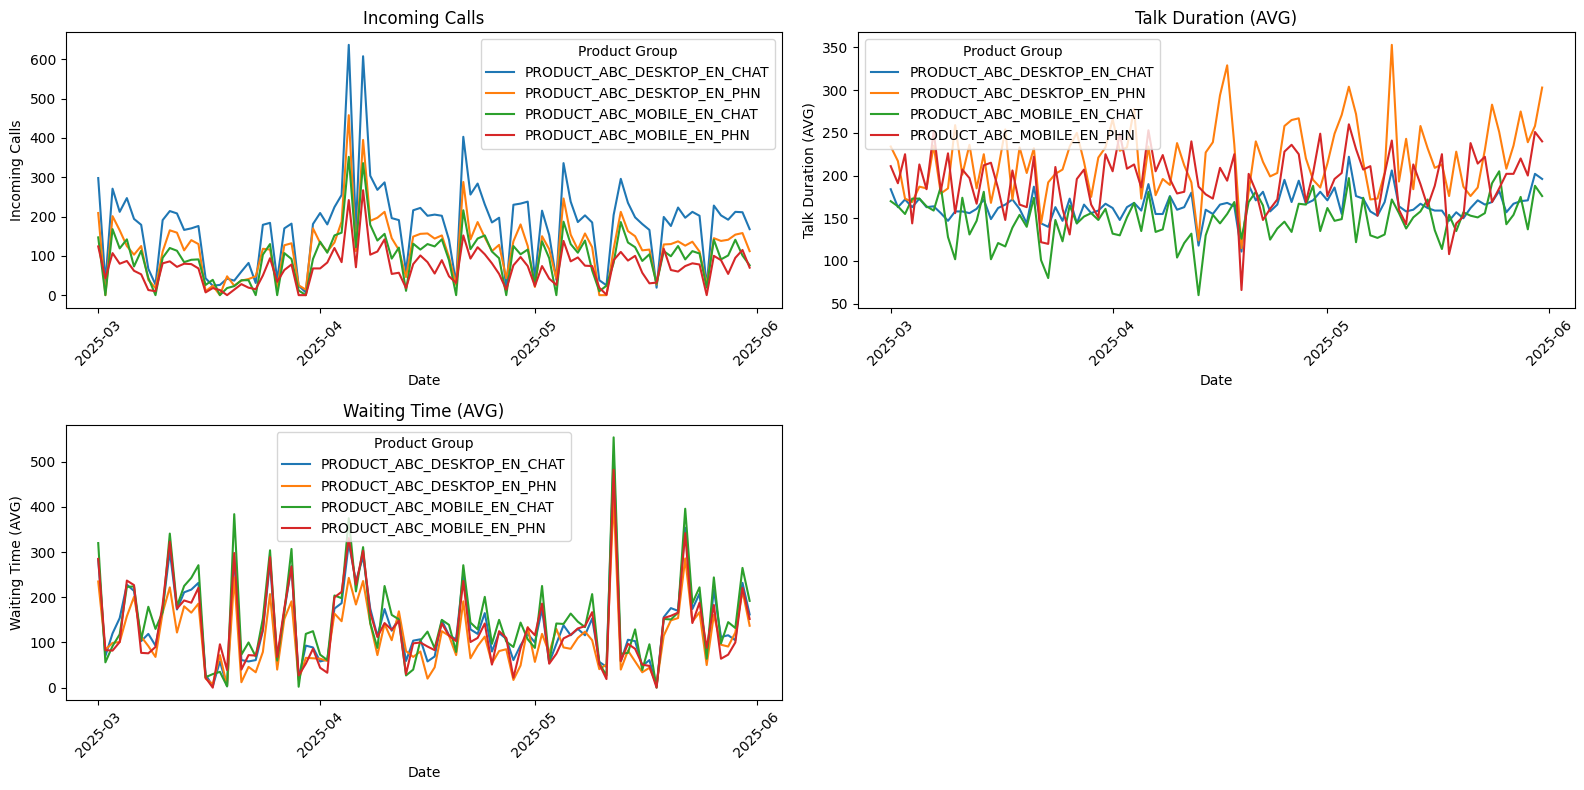

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plot_cols = ["Incoming Calls", "Talk Duration (AVG)", "Waiting Time (AVG)"]

# Ensure Date column is datetime
if not pd.api.types.is_datetime64_any_dtype(new_df["Date"]):
    new_df["Date"] = pd.to_datetime(new_df["Date"])

for idx, col in enumerate(plot_cols):
    ax = axes.flat[idx]
    sns.lineplot(x="Date", y=col, hue="Product Group", data=new_df, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Date")
    ax.set_ylabel(col)
    # Set x-axis ticks to monthly start
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis="x", rotation=45)
# Hide unused subplot if any
if len(axes.flat) > len(plot_cols):
    axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots(figsize=(16, 5))
# ax = sns.lineplot(x="Date", y="Incoming Calls", data=new_df, hue="Product Group")

In [39]:
new_df.to_csv("./data/call-center-data-v3-daily.csv", index=False)

# Intraday Curves

In [ ]:
# Generate intraday distributions by day of week (30-minute intervals)
profile_rng = np.random.default_rng(100)

time_slots = pd.date_range("00:00", "23:30", freq="30min")
minutes_since_midnight = time_slots.hour * 60 + time_slots.minute
active_mask = (minutes_since_midnight >= 8 * 60) & (
    minutes_since_midnight <= 17 * 60 + 30
)

day_names = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]


def gaussian_mixture_curve():
    base_curve = np.zeros_like(minutes_since_midnight, dtype=float)

    peak1 = profile_rng.normal(loc=11 * 60, scale=28)
    peak1 = np.clip(peak1, 10 * 60, 13 * 60)
    sigma1 = profile_rng.uniform(80, 100)
    amplitude1 = profile_rng.uniform(1, 1.2)

    peak2 = profile_rng.normal(loc=13 * 60, scale=25)
    peak2 = np.clip(peak2, 12 * 60, 14 * 60 + 30)
    sigma2 = profile_rng.uniform(120, 180)
    amplitude2 = profile_rng.uniform(0.8, 1)

    for peak, sigma, amplitude in [
        (peak1, sigma1, amplitude1),
        (peak2, sigma2, amplitude2),
    ]:
        base_curve += amplitude * np.exp(
            -0.5 * ((minutes_since_midnight - peak) / sigma) ** 2
        )

    normalized_curve = np.zeros_like(base_curve)
    noise = profile_rng.normal(loc=0, scale=0.03, size=base_curve.shape)
    base_curve = np.where(active_mask, base_curve + noise, 0)
    active_total = base_curve[active_mask].sum()
    if active_total > 0:
        normalized_curve[active_mask] = base_curve[active_mask] / active_total
    return normalized_curve


source_df = globals().get("new_df", df)
product_groups = sorted(source_df["Product Group"].unique())

intraday_records = []
for product_name in product_groups:
    for day_name in day_names:
        curve = gaussian_mixture_curve()
        for slot, share in zip(time_slots, curve):
            intraday_records.append(
                {
                    "Product Group": product_name,
                    "Day of Week": day_name,
                    "Interval Start": slot.strftime("%H:%M:%S"),
                    "Intraday Arrival": float(share),
                }
            )

intraday_profiles = pd.DataFrame(intraday_records)

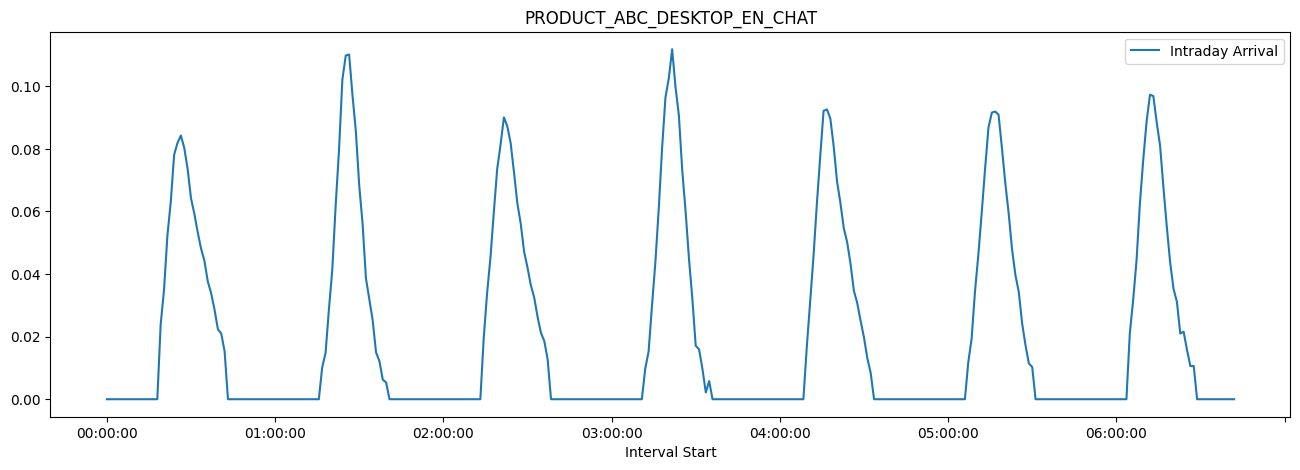

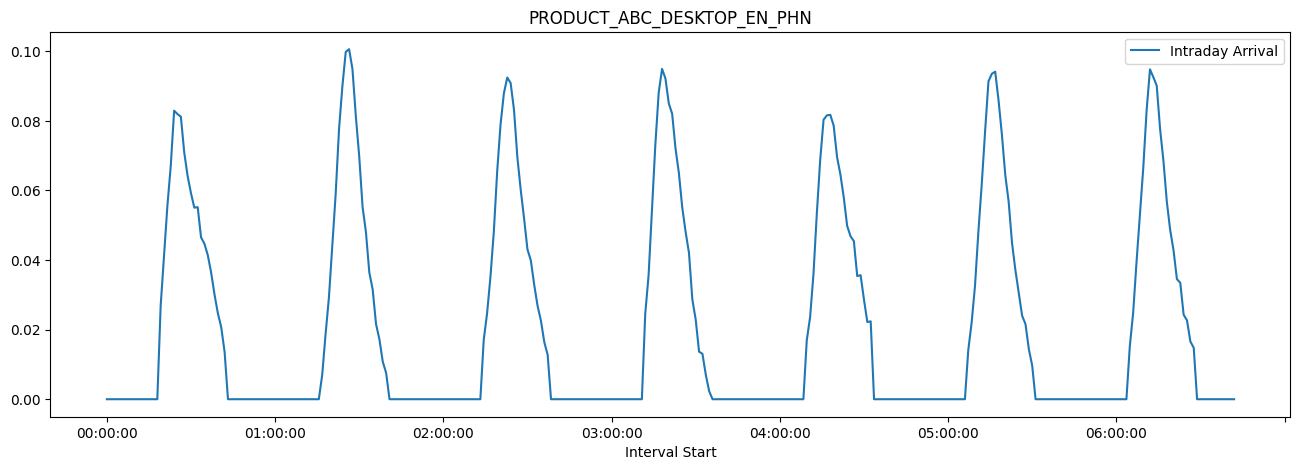

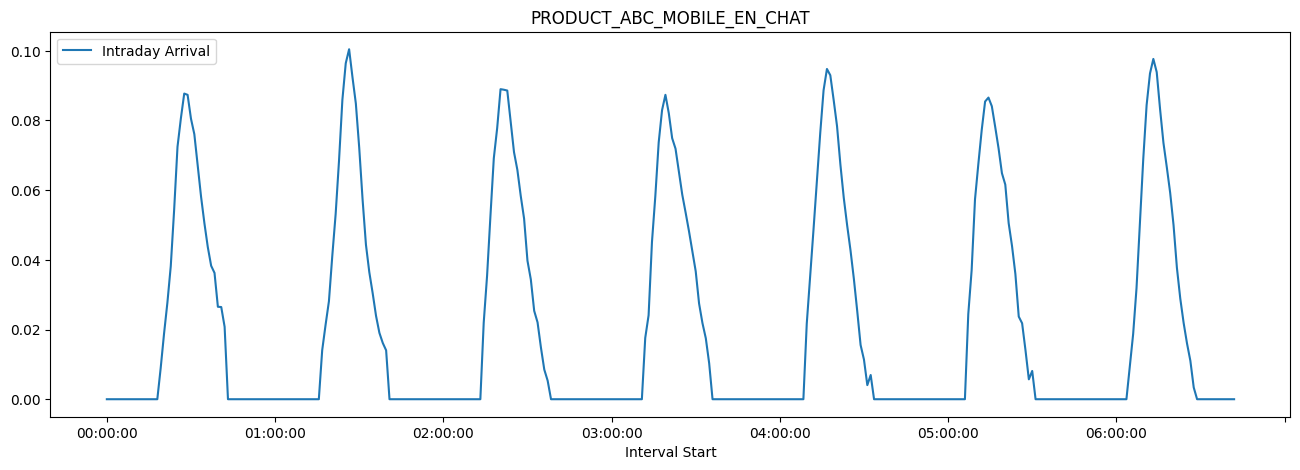

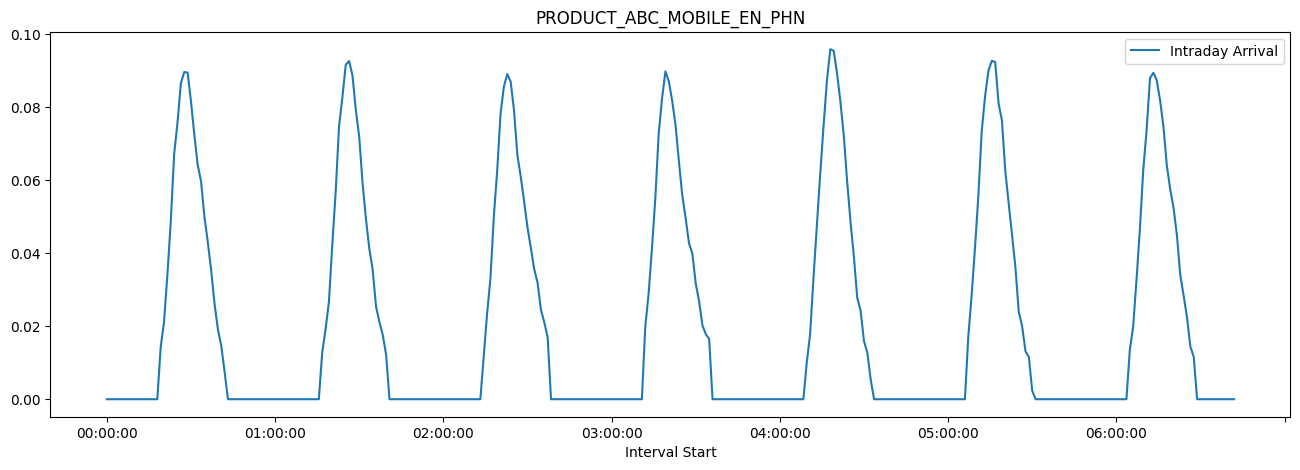

In [264]:
for product_name in product_groups:
    temp = intraday_profiles[
        (intraday_profiles["Product Group"] == product_name)
        # & (intraday_profiles["Day of Week"] == "Friday")
    ]
    temp.plot(
        x="Interval Start", y="Intraday Arrival", figsize=(16, 5), title=product_name
    )
    plt.show()

In [265]:
intraday_profiles.head()

,Product Group,Day of Week,Interval Start,Intraday Arrival
0,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,00:00:00,0.0
1,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,00:30:00,0.0
2,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,01:00:00,0.0
3,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,01:30:00,0.0
4,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,02:00:00,0.0


In [266]:
intraday_profiles.to_csv("./data/intraday-profiles.csv", index=False)